In [ ]:
%matplotlib qt
import mne
import numpy as np
import matplotlib.pyplot as plt
import os.path as op

from mne.minimum_norm import make_inverse_operator, apply_inverse

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
mne.set_log_level('WARNING')

In [2]:
FIRST_EV = [65.583, 67.787, 68.485, 51.884, 48.919, 55.836, 1, 93, 48.372, 55.292, 64.907, 68.374, 66.375, 66.901, 67.261]

In [3]:
def var_reject(epochs, plow, phigh, to_plot=True):
    """
    Variance based trial rejection function
    """
    badtrls = []
    trl_var, trlindx = np.empty((0,1),'float'), np.arange(0,len(epochs))
    for trnum in range(len(epochs)):
        trl_var = np.vstack((trl_var, max(np.var(np.squeeze(epochs[trnum].get_data()), axis=1))))
    lim1 = (trl_var < np.percentile(trl_var, plow, interpolation='midpoint')).flatten()
    lim2 = (trl_var > np.percentile(trl_var, phigh, interpolation='midpoint')).flatten()
    outlr_idx = trlindx[lim1].tolist() + trlindx[lim2].tolist()
    
    if to_plot:
        plt.figure(), plt.scatter(trlindx, trl_var, marker='o', s=50, c='g', label='Good trials'),
        plt.ylabel('Max. variance across channels-->')
        plt.scatter(outlr_idx, trl_var[outlr_idx], marker='o', s=50, c='r', label='Variance based bad trials'),
        plt.xlabel('Trial number-->')
        plt.scatter(badtrls, trl_var[badtrls], marker='o', s=50, c='orange', label='Manually assigned bad trials')
        plt.ylim(min(trl_var)-min(trl_var)*0.01, max(trl_var)+max(trl_var)*0.01), plt.title('Max. variance distribution')
        plt.legend()
        plt.show()
    bad_trials = np.union1d(badtrls, outlr_idx)
#     print('Trials to be removed: %s\n'%bad_trials)
    return bad_trials

In [4]:
def set_params(iSub, ctrlwin=[-0.5, 0], actiwin=[0, 1], plow=2, phigh=98, dominant_brain="right"):
    """
    Set parameters, directories and filenames for the subject
    """

    par = {'ctrlwin': ctrlwin, 'actiwin': actiwin}
    par['plow'], par['phigh'] = plow, phigh

    par['data_dir'] = op.expanduser("~/data/pic-name-data-bids/")
    sSub = '%02d' % iSub
    session , task, run = '01', 'picturenaming', '01'

    par['data_path'] = op.join(par['data_dir'], 'MEG')
    subjects_dir = op.join(par['data_dir'], 'MRI')
    subject = 'sub-' + sSub
    par['res_dir'] = op.join(op.expanduser("~/research/results/picname"), subject)

    par['bids_fname'] = subject + '_ses-' + session + '_task-' + task + '_run-' + run + '_meg.fif'
    par['bids_path'] = op.join(par['data_path'], subject, 'ses-'+session, 'meg')
    par['raw_fname'] = op.join(par['bids_path'], par['bids_fname'])
    par['trans_fname'] = op.join(par['bids_path'], subject+'-trans.fif')
    par['fwd_fname'] = op.join(par['bids_path'], subject + '-cort-meg-fwd.fif')
    par['mrifile'] = op.join(subjects_dir, subject, 'mri/T1.mgz')
    par['surffile'] = op.join(subjects_dir, subject, 
                              'bem/watershed', subject+'_brain_surface')
    par['stc_fname'] = op.join(par['res_dir'], 'dspm_' + subject)
    par['info'] = mne.io.read_info(par['raw_fname'])
    par['dominant_brain'] = dominant_brain
    
    # Set time instant for cropping raw data in the beginning
    par['raw_tmin'] = FIRST_EV[iSub-1] - 0.501
    
    # Changing of EEG channels to EOG/ECG
    if subject == 'sub-06':
        par['change_eeg_channels'] = True
    else:
        par['change_eeg_channels'] = False
        
    # Applying EOG/ECG SSP
    if iSub in [1, 2, 3, 4, 6]:
        par['apply_ssp_eog'] = True
        par['apply_ssp_ecg'] = True
    elif iSub in range(7, 16):
        par['apply_ssp_eog'] = True
        par['apply_ssp_ecg'] = False
    elif iSub == 100:
        par['apply_ssp_eog'] = False
        par['apply_ssp_ecg'] = True
    elif iSub == 5:
        par['apply_ssp_eog'] = False
        par['apply_ssp_ecg'] = False
    
    return par, subject, subjects_dir

In [5]:
more_plots = False
par, subject, subjects_dir = set_params(15, dominant_brain='right')

In [6]:
par['raw_tmin']

66.75999999999999

In [7]:
raw = mne.io.read_raw_fif(par['raw_fname'], allow_maxshield=False, preload=True, verbose=True)
raw.crop(tmin=par['raw_tmin'], tmax=None)

Opening raw data file /home/anakin/data/pic-name-data-bids/MEG/sub-15/ses-01/meg/sub-15_ses-01_task-picturenaming_run-01_meg.fif...
    Range : 27000 ... 515999 =     27.000 ...   515.999 secs
Ready.
Reading 0 ... 488999  =      0.000 ...   488.999 secs...


<Raw | sub-15_ses-01_task-picturenaming_run-01_meg.fif, 320 x 422240 (422.2 s), ~1.01 GB, data loaded>

In [8]:
events = mne.find_events(raw, stim_channel='STI101',
                              min_duration=0.002, shortest_event=2)
delay = int(round(0.056 * raw.info['sfreq']))
events[:, 0] = events[:, 0] + delay

In [9]:
len(events)

83

In [10]:
if more_plots:
    mne.viz.plot_events(events, first_samp=0, event_id=None,
                       equal_spacing=True, show=True)

In [11]:
if par['change_eeg_channels']:
    print("Renaming EEG channels and changing channel types for subject:", subject)
    raw.set_channel_types({'EEG061': 'eog', 'EEG062': 'ecg'})
    raw.rename_channels({'EEG061': 'EOG061', 'EEG062': 'ECG062'})

In [12]:
if par['apply_ssp_eog']:
    print('Computing EOG projectors')
    # Create EOG projectors and apply SSP
    eog_epochs = mne.preprocessing.create_eog_epochs(raw)
    eog_epochs.average().plot_joint()
    plt.savefig(op.join(par['res_dir'], 'eog_evoked_' + subject + '.pdf'))
    projs_eog, _ = mne.preprocessing.compute_proj_eog(raw, n_mag=3, n_grad=3, average=True)

Computing EOG projectors
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 sec)



In [13]:
if par['apply_ssp_ecg']:
    print('Computing ECG projectors')
    # Create ECG projectors and apply SSP
    ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
    ecg_epochs.average().plot_joint()
    plt.savefig(op.join(par['res_dir'], 'ecg_evoked_' + subject + '.pdf'))
    projs_ecg, _ = mne.preprocessing.compute_proj_ecg(raw, n_mag=3, n_grad=3, average=True)

In [14]:
picks = mne.pick_types(raw.info, meg=True, exclude='bads')

In [15]:
raw.filter(1, 20, picks=picks, filter_length='auto', n_jobs=1,
      method='fir', iir_params=None, phase='zero', fir_window='hamming',
      fir_design='firwin', skip_by_annotation=('edge', 'bad_acq_skip'),
      pad='reflect_limited', verbose=True)
if more_plots:
    raw.plot_psd(fmin=0, fmax=25, proj=False, verbose=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3301 samples (3.301 sec)



In [16]:
epochs = mne.Epochs(raw, events, tmin=par['ctrlwin'][0], tmax=par['actiwin'][1],
                   baseline=(par['ctrlwin'][0],par['ctrlwin'][1]), picks=picks, 
                   preload=True, proj=False, verbose=True)

Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
Loading data for 83 events and 1501 original time points ...
0 bad epochs dropped


In [17]:
# Add desirable projectors
if par['apply_ssp_eog'] & par['apply_ssp_ecg']:
    print('EOG+ECG:', subject)
    epochs.del_proj()
    epochs.add_proj(projs_eog[::3] + projs_ecg[::3]);
    epochs.apply_proj();
elif par['apply_ssp_eog'] | par['apply_ssp_ecg']:
    if par['apply_ssp_eog']:
        print('EOG:', subject)
        epochs.del_proj()
        epochs.add_proj(projs_eog[::3]);
        epochs.apply_proj();
    else:
        print('ECG:', subject)
        epochs.del_proj()
        epochs.add_proj(projs_ecg[::3]);
        epochs.apply_proj();
else:
    print('No SSP:', subject)
    epochs.del_proj()

EOG: sub-15
2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...


In [18]:
bad_trials = var_reject(epochs, par['plow'], par['phigh'], to_plot=True)
plt.savefig(op.join(par['res_dir'], 'trial_variances_' + subject + '.pdf'))
epochs.drop(bad_trials, reason='variance based rejection', verbose=True);

Dropped 4 epochs: 31.0, 45.0, 55.0, 63.0


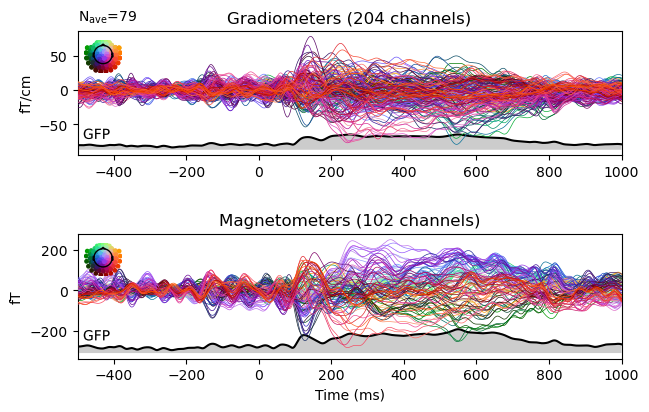

In [19]:
evoked = epochs.average()
evoked.plot(spatial_colors=True, gfp=True, time_unit='ms')

In [20]:
fwd = mne.read_forward_solution(par['fwd_fname'])

In [21]:
noise_cov = mne.compute_covariance(epochs,
                tmin=par['ctrlwin'][0], tmax=par['ctrlwin'][1],
                method=['shrunk', 'empirical'], rank='info', verbose=True)

Computing rank from data with rank='info'
    MEG: rank 68 after 2 projectors applied to 306 channels
    Created an SSP operator (subspace dimension = 2)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 68
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 39579
log-likelihood on unseen data (descending order):
   shrunk: -414.960
   empirical: -414.969
selecting best estimator: shrunk
[done]


In [22]:
inverse_operator = make_inverse_operator(par['info'], fwd, noise_cov, loose=0.2, depth=0.8)

In [23]:
method, lambda2 = "dSPM", 1 / 3 ** 2
stc = apply_inverse(evoked, inverse_operator, lambda2, method=method, pick_ori=None)

In [24]:
plt.figure()
plt.plot(1e3 * stc.times, stc.data[::100, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('%s value' % method)
plt.savefig(op.join(par['res_dir'], 'evoked_dspm_100_' + subject + '.pdf'))